In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [22]:
def plot_function_3d(func, x_range, y_range, title=""):

    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func(np.array([xi, yi])) for xi in x] for yi in y])
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()

def plot_function_contour(func, x_range, y_range, title=""):

    x = np.linspace(x_range[0], x_range[1], 200)
    y = np.linspace(y_range[0], y_range[1], 200)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[func(np.array([xi, yi])) for xi in x] for yi in y])
    
    plt.figure(figsize=(8,6))
    cp = plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(cp)
    plt.show()
    
# plot_function_3d(ackley, (-5, 5), (-5, 5), title="Ackley Function (3D Surface)")
# plot_function_contour(ackley, (-5, 5), (-5, 5), title="Ackley Function (Contour)")

# plot_function_3d(rosenbrock, (-2, 2), (-1, 3), title="Rosenbrock Function (3D Surface)")
# plot_function_contour(rosenbrock, (-2, 2), (-1, 3), title="Rosenbrock Function (Contour)")

# plot_function_3d(cross_in_tray, (-10, 10), (-10, 10), title="Cross-in-tray Function (3D Surface)")
# plot_function_contour(cross_in_tray, (-10, 10), (-10, 10), title="Cross-in-tray Function (Contour)")

# plot_function_3d(holder_table, (-10, 10), (-10, 10), title="Holder Table Function (3D Surface)")
# plot_function_contour(holder_table, (-10, 10), (-10, 10), title="Holder Table Function (Contour)")

# plot_function_3d(mccormick, (-1.5, 4), (-3, 4), title="McCormick Function (3D Surface)")
# plot_function_contour(mccormick, (-1.5, 4), (-3, 4), title="McCormick Function (Contour)")

# plot_function_3d(styblinski_tang, (-5, 5), (-5, 5), title="Styblinski–Tang Function (3D Surface)")
# plot_function_contour(styblinski_tang, (-5, 5), (-5, 5), title="Styblinski–Tang Function (Contour)")

In [86]:

class Particle:
    def __init__(self, dim, pos_bounds, vel_bounds):
        """
        Initializes a particle with random position and velocity.
        
        Parameters:
            dim (int): Dimensionality of the search space.
            pos_bounds (tuple): (x_min, x_max) boundaries for positions.
            vel_bounds (tuple): (v_min, v_max) boundaries for velocities.
        """
        self.dim = dim
        self.pos_bounds = pos_bounds
        self.vel_bounds = vel_bounds
        self.position = np.random.uniform(pos_bounds[0], pos_bounds[1], dim)
        self.velocity = np.random.uniform(vel_bounds[0], vel_bounds[1], dim)
        self.best_position = self.position.copy()
        self.best_score = float('inf')

    def update_velocity(self, global_best, w, alpha1, alpha2):
        """
        Updates the particle's velocity based on inertia, cognitive, and social components.
        
        Parameters:
            global_best (ndarray): The best position found by the swarm.
            w (float): Inertia weight.
            alpha1 (float): Cognitive acceleration coefficient.
            alpha2 (float): Social acceleration coefficient.
        """
        r1, r2 = np.random.rand(2)
        cognitive = alpha1 * r1 * (self.best_position - self.position)
        social = alpha2 * r2 * (global_best - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def update_position(self):
        """
        Updates the particle's position based on its velocity and applies boundary reflection.
        """
        self.position += self.velocity
        # Reflect the particle if it goes out of bounds
        for j in range(self.dim):
            if self.position[j] < self.pos_bounds[j, 0]:
                self.position[j] = self.pos_bounds[j, 0] + abs(self.position[j] - self.pos_bounds[j, 0])
                self.velocity[j] = -self.velocity[j]
            elif self.position[j] > self.pos_bounds[j, 1]:
                self.position[j] = self.pos_bounds[j, 1] - abs(self.position[j] - self.pos_bounds[j, 1])
                self.velocity[j] = -self.velocity[j]

class PSO:
    def __init__(self, fitness_func, num_particles, dim, pos_bounds, vel_bounds, max_iter, 
                 alpha1, alpha2, w_max, w_min, 
                 enable_shaking=False, stagnation_iter=50, shake_probability=0.5, shake_amplitude=0.1,
                 target_global_min=None, epsilon_target=None, epsilon_stagnation=1e-6):
        """
        Parameters:
            fitness_func (callable): The objective function.
            num_particles (int): Number of particles.
            dim (int): Dimensionality of the search space.
            pos_bounds (tuple): (x_min, x_max) boundaries for positions.
            vel_bounds (tuple): (v_min, v_max) boundaries for velocities.
            max_iter (int): Maximum number of iterations.
            alpha1, alpha2 (float): Acceleration coefficients.
            w_max, w_min (float): Maximum and minimum inertia weights.
            enable_shaking (bool): Whether to enable the shaking mechanism.
            stagnation_iter (int): Iterations with negligible improvement before shaking is triggered.
            shake_probability (float): Probability that a particle is shaken.
            shake_amplitude (float): Amplitude of the shake (fraction of the position range).
            target_global_min (float): Stop if the global best score is below this value.
            epsilon_target (float): Stop if the difference between global best score and the target is less than this.
            epsilon_stagnation (float): Threshold for change in global best score to be considered as stagnation.
        """
        self.fitness_func = fitness_func
        self.num_particles = num_particles
        self.dim = dim
        self.pos_bounds = pos_bounds
        self.vel_bounds = vel_bounds
        self.max_iter = max_iter
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.w_max = w_max
        self.w_min = w_min
        self.enable_shaking = enable_shaking
        self.stagnation_iter = stagnation_iter
        self.shake_probability = shake_probability
        self.shake_amplitude = shake_amplitude
        self.target_global_min = target_global_min
        self.epsilon_target = epsilon_target
        self.epsilon_stagnation = epsilon_stagnation
        
        # Create the swarm of particles
        self.swarm = [Particle(dim, pos_bounds, vel_bounds) for _ in range(num_particles)]
        self.global_best_position = None
        self.global_best_score = float('inf')
        self.history_best_positions = []  
        self.history_all_positions = []   
        
        # Initialize global best from the swarm
        for particle in self.swarm:
            score = self.fitness_func(particle.position)
            particle.best_score = score
            if score < self.global_best_score:
                self.global_best_score = score
                self.global_best_position = particle.position.copy()
    
    def shake_particles(self):
        """
        Applies a random perturbation to particle positions and reinitializes velocities.
        """
        range_pos = np.abs(self.pos_bounds[1] - self.pos_bounds[0])  # Убедимся, что разница положительная
        
        # Используем np.maximum, чтобы корректно обработать массив
        shake_std = np.maximum(self.shake_amplitude * range_pos, 1e-6)

        shaken_count = 0
        for particle in self.swarm:
            if np.random.rand() < self.shake_probability:
                noise = np.random.normal(0, shake_std, self.dim)
                particle.position += noise
                particle.velocity = np.random.uniform(self.vel_bounds[0], self.vel_bounds[1], self.dim)
                particle.best_position = particle.position.copy()
                particle.best_score = self.fitness_func(particle.position)
                shaken_count += 1
        print(f"Shaken {shaken_count} particles.")

    def run(self):
        """
        Executes the PSO algorithm.
        
        Returns:
            (global_best_position, global_best_score, history_best_positions, history_all_positions)
        """
        stagnation_count = 0
        previous_best = self.global_best_score
        
        for iteration in range(self.max_iter):
            # Update inertia weight linearly
            w = self.w_max - ((self.w_max - self.w_min) * iteration / self.max_iter)
            for particle in self.swarm:
                particle.update_velocity(self.global_best_position, w, self.alpha1, self.alpha2)
                particle.update_position()
                score = self.fitness_func(particle.position)
                # Update personal best for each particle
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                # Update global best for the swarm
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
            
            # Save history of the global best position and all particle positions
            self.history_best_positions.append(self.global_best_position.copy())
            iteration_positions = [particle.position.copy() for particle in self.swarm]
            self.history_all_positions.append(iteration_positions)
            
            # Check stagnation: if the improvement is less than epsilon_stagnation, increase counter
            if abs(previous_best - self.global_best_score) < self.epsilon_stagnation:
                stagnation_count += 1
            else:
                stagnation_count = 0
                previous_best = self.global_best_score
            
            # Trigger shaking if stagnation persists
            if self.enable_shaking and stagnation_count >= self.stagnation_iter:
                print(f"Stagnation reached at iteration {iteration}. Shaking particles...")
                self.shake_particles()
                stagnation_count = 0  # Reset stagnation counter
            
            # Check stopping conditions based on target global minimum
            if self.target_global_min is not None:
                if self.global_best_score <= self.target_global_min:
                    print(f"Target global minimum {self.target_global_min} reached at iteration {iteration}. Stopping.")
                    break
                if self.epsilon_target is not None and abs(self.global_best_score - self.target_global_min) < self.epsilon_target:
                    print(f"Global minimum is within epsilon {self.epsilon_target} of target at iteration {iteration}. Stopping.")
                    break
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Global best score = {self.global_best_score}")
        
        return self.global_best_position, self.global_best_score, self.history_best_positions, self.history_all_positions

# Visualisation

In [ ]:
def ackley(x, a=20, b=0.2, c=2*np.pi):
    d = len(x)
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / d))
    term2 = -np.exp(sum_cos / d)
    return term1 + term2 + a + np.exp(1)

def rosenbrock(x):
    return np.sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def cross_in_tray(x):
    term1 = np.sin(x[0]) * np.sin(x[1])
    term2 = np.exp(np.abs(100 - np.sqrt(x[0]**2 + x[1]**2)/np.pi))
    return -0.0001 * (np.abs(term1 * term2) + 1)**0.1

def holder_table(x):
    return -np.abs(np.sin(x[0]) * np.cos(x[1]) * 
                   np.exp(np.abs(1 - np.sqrt(x[0]**2 + x[1]**2)/np.pi)))

def mccormick(x):
    return np.sin(x[0] + x[1]) + (x[0] - x[1])**2 - 1.5*x[0] + 2.5*x[1] + 1

def styblinski_tang(x):
    return 0.5 * np.sum(x**4 - 16*x**2 + 5*x)


In [75]:
func_info = {
    "ackley": (ackley, (-5, 5), (-5, 5), (0, 0), 0),
    "rosenbrock": (rosenbrock, (-5, 5), (-5, 5), (1, 1), 0),
    "cross_in_tray": (cross_in_tray, (-10, 10), (-10, 10), (1.34941, 1.34941), -2.06261),
    "holder_table": (holder_table, (-10, 10), (-10, 10), (8.05502, 9.66459), -19.2085),
    "mccormick": (mccormick, (-1.5, 4), (-3, 4), (-0.54719, -1.54719), -1.9133),
    "styblinski_tang": (styblinski_tang, (-5, 5), (-5, 5), (-2.903534, -2.903534), -78.33198)
}

## Find optimal parametrs

In [40]:
num_runs = 10
num_particles_values = [20, 50, 100, 250]
alpha1_values = [0.5, 1, 1.5, 2]
alpha2_values = [0.5, 1, 1.5, 2]
results = {}

max_iter = 500
w_max = 0.9
w_min = 0.2
epsilon_target = 1e-6

enable_shaking = False
stagnation_iter = 50
shake_probability = 0.5
shake_amplitude = 0.3
epsilon_stagnation = 1e-6


start = True

if start:
    for func_name, (func, x_bound, y_bound, best_point, theoretical_min) in func_info.items():
        bounds = np.array([x_bound, y_bound])
        
        best_avg_cost = None
        best_params = None
        param_results = {}
        
        for n in num_particles_values:
            for a1 in alpha1_values:
                for a2 in alpha2_values:
                    cost_list = []
                    for run in range(num_runs):
                        pso_solver = PSO(func, n, 2, bounds, (-2, 2), max_iter,
                                        a1, a2, w_max, w_min,
                                        enable_shaking, stagnation_iter, shake_probability, shake_amplitude,
                                        target_global_min=theoretical_min, epsilon_target=epsilon_target, epsilon_stagnation=epsilon_stagnation)
                        _, best_score, history_best_positions, _ = pso_solver.run()
                        iters = len(history_best_positions)
                        cost = n * iters  # Total cost: number of particles multiplied by iterations
                        cost_list.append(cost)
                    
                    avg_cost = np.mean(cost_list)
                    param_results[(n, a1, a2)] = avg_cost
                    
                    if best_avg_cost is None or avg_cost < best_avg_cost:
                        best_avg_cost = avg_cost
                        best_params = (n, a1, a2)
        
        results[func_name] = (best_params, best_avg_cost, param_results)
        print(f"Function: {func_name}")
        print(f"Best parameters: num_particles = {best_params[0]}, alpha1 = {best_params[1]}, alpha2 = {best_params[2]}")
        print(f"Average cost (num_particles * iterations): {best_avg_cost:.2f}")
        print("-" * 50)


Iteration 0: Global best score = 11.913942381520288
Iteration 10: Global best score = 0.14593818526602975
Iteration 20: Global best score = 0.04333972870514957
Iteration 30: Global best score = 0.019275624819279802
Iteration 40: Global best score = 0.018520450969628843
Iteration 50: Global best score = 0.009990014005648806
Iteration 60: Global best score = 0.003961179131359405
Iteration 70: Global best score = 0.003317390730881886
Iteration 80: Global best score = 0.003268444707150042
Iteration 90: Global best score = 0.002375040322835975
Iteration 100: Global best score = 0.0006098709028994342
Iteration 110: Global best score = 2.1749254259351147e-05
Iteration 120: Global best score = 2.2758070277184572e-06
Global minimum is within epsilon 1e-06 of target at iteration 128. Stopping.
Iteration 0: Global best score = 9.911577119486378
Iteration 10: Global best score = 0.265918523266198
Iteration 20: Global best score = 0.1597311283082239
Iteration 30: Global best score = 0.0862419923801

C:\Users\grund\AppData\Local\Temp\ipykernel_12940\3465103297.py:19: RuntimeWarning: overflow encountered in exp
  np.exp(np.abs(1 - np.sqrt(x[0]**2 + x[1]**2)/np.pi)))


Target global minimum -19.2085 reached at iteration 42. Stopping.
Iteration 0: Global best score = -18.773755782542555
Iteration 10: Global best score = -19.20691859252451
Iteration 20: Global best score = -19.20691859252451
Target global minimum -19.2085 reached at iteration 30. Stopping.
Iteration 0: Global best score = -18.781719101859576
Iteration 10: Global best score = -19.15726486609074
Iteration 20: Global best score = -19.2047070926859
Target global minimum -19.2085 reached at iteration 25. Stopping.
Iteration 0: Global best score = -18.280596585282538
Iteration 10: Global best score = -19.18753655821022
Iteration 20: Global best score = -19.20501589702121
Iteration 30: Global best score = -19.207992558852116
Target global minimum -19.2085 reached at iteration 34. Stopping.
Iteration 0: Global best score = -19.069896276715927
Iteration 10: Global best score = -19.20370543296793
Iteration 20: Global best score = -19.207600623956203
Target global minimum -19.2085 reached at iter

In [42]:
for func_name, (best_params, best_avg_cost, param_results) in results.items():
    print(f"Function: {func_name}")
    print(f"Best parameters: num_particles = {best_params[0]}, alpha1 = {best_params[1]}, alpha2 = {best_params[2]}")
    print(f"Average cost (num_particles * iterations): {best_avg_cost:.2f}")
    print("-" * 50)

Function: ackley
Best parameters: num_particles = 20, alpha1 = 1, alpha2 = 0.5
Average cost (num_particles * iterations): 2566.00
--------------------------------------------------
Function: rosenbrock
Best parameters: num_particles = 20, alpha1 = 1, alpha2 = 0.5
Average cost (num_particles * iterations): 2062.00
--------------------------------------------------
Function: cross_in_tray
Best parameters: num_particles = 20, alpha1 = 1.5, alpha2 = 0.5
Average cost (num_particles * iterations): 1142.00
--------------------------------------------------
Function: holder_table
Best parameters: num_particles = 20, alpha1 = 2, alpha2 = 2
Average cost (num_particles * iterations): 310.00
--------------------------------------------------
Function: mccormick
Best parameters: num_particles = 250, alpha1 = 2, alpha2 = 2
Average cost (num_particles * iterations): 3075.00
--------------------------------------------------
Function: styblinski_tang
Best parameters: num_particles = 20, alpha1 = 1.5, 

## Visulise process of finding global minimum

In [53]:
best_params = {
    "styblinski_tang": (20, 1, 0.5),
    "mccormick": (20, 1, 0.5),
    "holder_table": (20, 1.5, 0.5),
    "ackley": (20, 2, 2),
    "cross_in_tray": (250, 2, 2),
    "rosenbrock": (500, 2, 2)
}

Running PSO for ackley with parameters: num_particles=20, alpha1=2, alpha2=2
Iteration 0: Global best score = 4.181280608407096
Iteration 10: Global best score = 0.7973439995016354
Iteration 20: Global best score = 0.25783657384810654
Iteration 30: Global best score = 0.25783657384810654
Iteration 40: Global best score = 0.25783657384810654
Iteration 50: Global best score = 0.25783657384810654
Iteration 60: Global best score = 0.15772253625798927
Iteration 70: Global best score = 0.15569106013254386
Iteration 80: Global best score = 0.14751752415568165
Iteration 90: Global best score = 0.03225365222546417
Iteration 100: Global best score = 0.0215685694450376
Iteration 110: Global best score = 0.0215685694450376
Iteration 120: Global best score = 0.013611764126022496
Iteration 130: Global best score = 0.0035637935555716815
Iteration 140: Global best score = 0.002311756835684964
Iteration 150: Global best score = 0.0008512134160452156
Iteration 160: Global best score = 0.0008512134160452

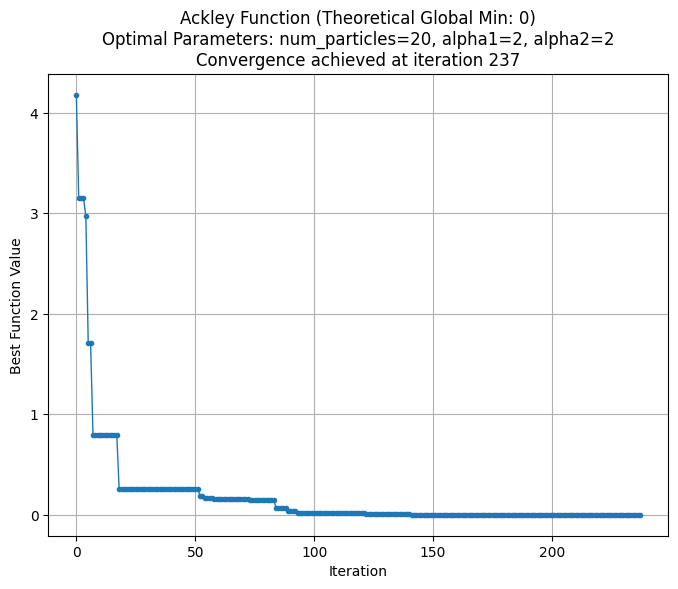

Running PSO for rosenbrock with parameters: num_particles=500, alpha1=2, alpha2=2
Iteration 0: Global best score = 0.11263517083502932
Iteration 10: Global best score = 0.018919100168084707
Iteration 20: Global best score = 0.013670723100766115
Iteration 30: Global best score = 0.013670723100766115
Iteration 40: Global best score = 0.008071085804939645
Iteration 50: Global best score = 0.0034458024429656437
Iteration 60: Global best score = 0.0005228758784877154
Iteration 70: Global best score = 3.941188461558805e-05
Iteration 80: Global best score = 3.941188461558805e-05
Iteration 90: Global best score = 3.941188461558805e-05
Iteration 100: Global best score = 3.941188461558805e-05
Iteration 110: Global best score = 2.9886296003460395e-06
Iteration 120: Global best score = 2.701819422963702e-06
Global minimum is within epsilon 1e-06 of target at iteration 123. Stopping.


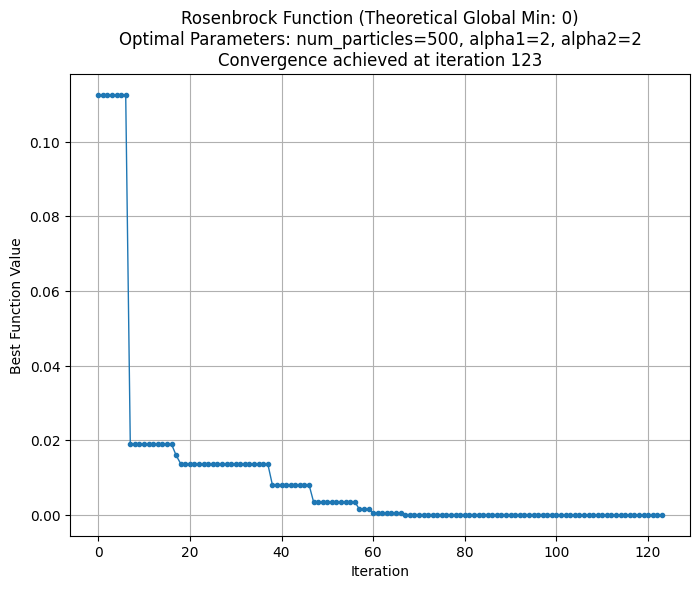

Running PSO for cross_in_tray with parameters: num_particles=250, alpha1=2, alpha2=2
Iteration 0: Global best score = -2.0469008831261197
Iteration 10: Global best score = -2.0621134897847213
Iteration 20: Global best score = -2.0624458373211385
Iteration 30: Global best score = -2.0624458373211385
Iteration 40: Global best score = -2.0624458373211385
Iteration 50: Global best score = -2.0625059387152023
Iteration 60: Global best score = -2.0625610843505644
Iteration 70: Global best score = -2.0625955898635233
Iteration 80: Global best score = -2.0625955898635233
Iteration 90: Global best score = -2.0625955898635233
Iteration 100: Global best score = -2.0625955898635233
Iteration 110: Global best score = -2.0625955898635233
Global minimum is within epsilon 1e-06 of target at iteration 113. Stopping.


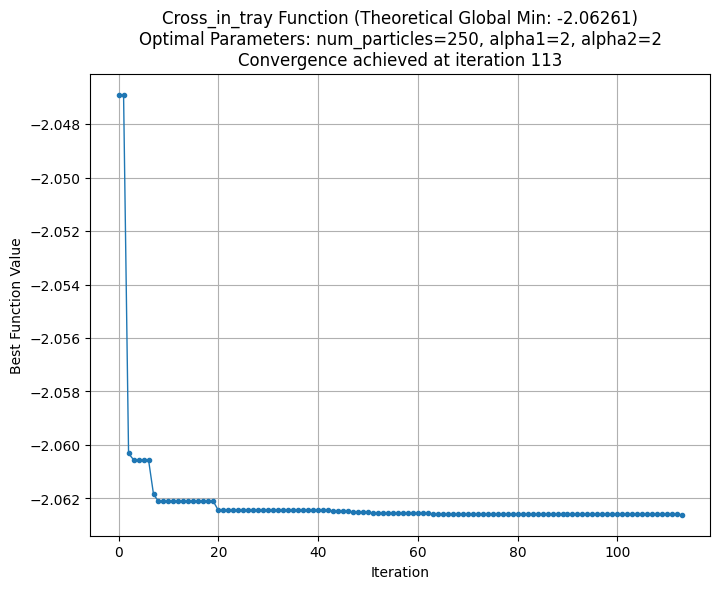

Running PSO for holder_table with parameters: num_particles=20, alpha1=1.5, alpha2=0.5
Iteration 0: Global best score = -17.76557816745969
Iteration 10: Global best score = -19.12556957769272
Iteration 20: Global best score = -19.208116939197126
Iteration 30: Global best score = -19.208116939197126
Iteration 40: Global best score = -19.20820085190269
Iteration 50: Global best score = -19.20825046112179
Iteration 60: Global best score = -19.208489176243802
Target global minimum -19.2085 reached at iteration 62. Stopping.


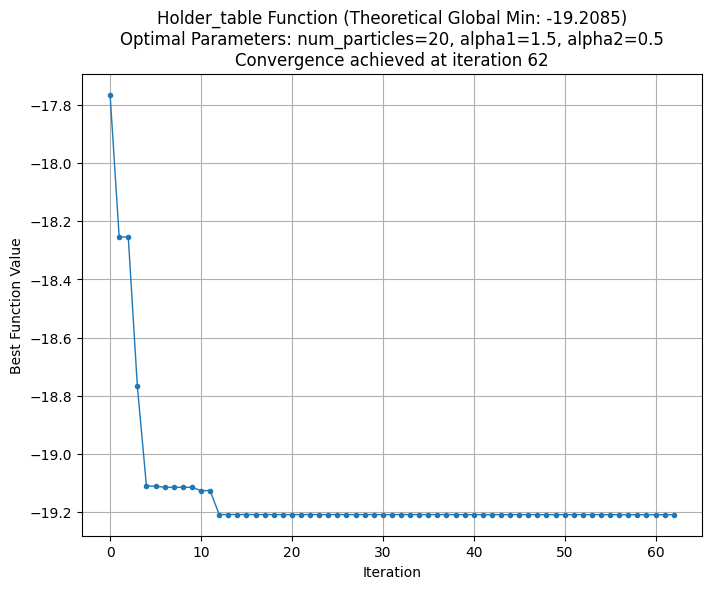

Running PSO for mccormick with parameters: num_particles=20, alpha1=1, alpha2=0.5
Iteration 0: Global best score = 9.298982627198804
Iteration 10: Global best score = -1.8762538360514371
Iteration 20: Global best score = -1.906880499970339
Iteration 30: Global best score = -1.9130269993514109
Iteration 40: Global best score = -1.9131504675060214
Iteration 50: Global best score = -1.9132094515778233
Iteration 60: Global best score = -1.9132203268754475
Iteration 70: Global best score = -1.9132203268754475
Iteration 80: Global best score = -1.9132227766789427
Iteration 90: Global best score = -1.9132229468670197
Iteration 100: Global best score = -1.9132229544069608
Iteration 110: Global best score = -1.913222954533257
Iteration 120: Global best score = -1.9132229549709616
Iteration 130: Global best score = -1.9132229549804878
Iteration 140: Global best score = -1.9132229549810327
Iteration 150: Global best score = -1.9132229549810362
Iteration 160: Global best score = -1.913222954981036

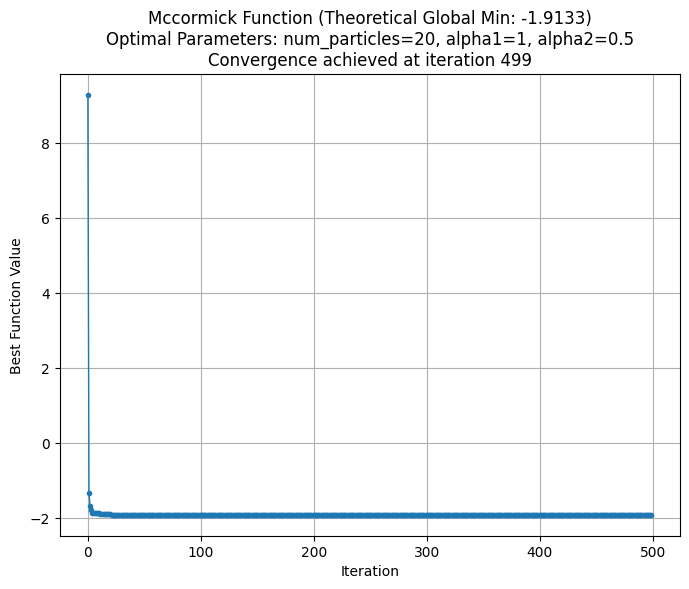

Running PSO for styblinski_tang with parameters: num_particles=20, alpha1=1, alpha2=0.5
Iteration 0: Global best score = -62.64936354266137
Iteration 10: Global best score = -64.12289735135114
Iteration 20: Global best score = -64.19228435605811
Iteration 30: Global best score = -76.42838029262758
Iteration 40: Global best score = -78.2847110569906
Iteration 50: Global best score = -78.31278897765893
Iteration 60: Global best score = -78.33112884420379
Iteration 70: Global best score = -78.33117845655812
Target global minimum -78.33198 reached at iteration 77. Stopping.


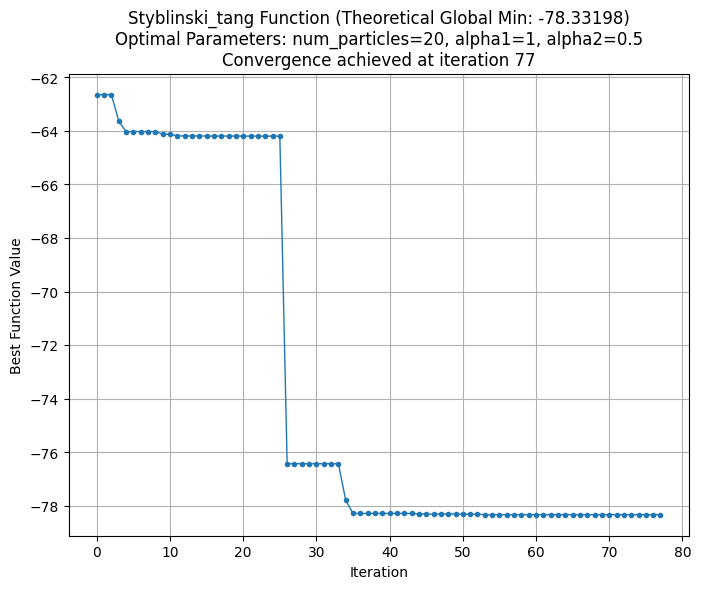

In [ ]:
w_max = 0.9
w_min = 0.2
max_iter = 500
enable_shaking = False
stagnation_iter = 50
shake_probability = 0.5
shake_amplitude = 0.1
epsilon_target = 1e-6
epsilon_stagnation = 1e-6

for func_name, (func, x_bound, y_bound, best_point, theoretical_min) in func_info.items():
    n, a1, a2 = best_params[func_name]
    bounds = np.array([x_bound, y_bound])
    
    print(f"Running PSO for {func_name} with parameters: num_particles={n}, alpha1={a1}, alpha2={a2}")
    
    pso_solver = PSO(func, n, 2, bounds, (-2, 2), max_iter,
                     a1, a2, w_max, w_min,
                     enable_shaking, stagnation_iter, shake_probability, shake_amplitude,
                     target_global_min=theoretical_min, epsilon_target=epsilon_target, epsilon_stagnation=epsilon_stagnation)
    global_best_position, best_score, history_best_positions, _ = pso_solver.run()

    history_best_values = [func(np.array(pos)) for pos in history_best_positions]
    iterations = np.arange(len(history_best_values))

    plt.figure(figsize=(8,6))
    plt.plot(iterations, history_best_values, marker='o', markersize=3, linewidth=1)
    plt.xlabel("Iteration")
    plt.ylabel("Best Function Value")
    plt.title(f"{func_name.capitalize()} Function (Theoretical Global Min: {theoretical_min})\n"
              f"Optimal Parameters: num_particles={n}, alpha1={a1}, alpha2={a2}\n"
              f"Convergence achieved at iteration {len(history_best_values)-1}")
    plt.grid(True)
    plt.show()


# GIFs

In [81]:
def create_surface_gif(func, bounds, best_points, all_populations, filename="optimization_surface", save_gif=False, show=False):
    """
    Creates an animated GIF using a 3D surface plot of the objective function.

    Parameters:
        func (callable): The objective function.
        bounds (ndarray): 2x2 array with bounds [[x_min, x_max], [y_min, y_max]].
        best_points (list): List of best point coordinates per iteration.
        all_populations (list): List of arrays containing all particle positions per iteration.
        filename (str): Base filename for the output GIF.
        save_gif (bool): If True, saves the animation as a GIF.
        show (bool): If True, displays the animation.

    Returns:
        ani (FuncAnimation): The animation object.
    """
    # Создание сетки для построения поверхности
    x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
    y = np.linspace(bounds[1, 0], bounds[1, 1], 100)
    X, Y = np.meshgrid(x, y)

    # Функция должна получать входные значения в виде массива shape (2,) и возвращать одно число
    def eval_func(X, Y):
        XY_pairs = np.column_stack((X.ravel(), Y.ravel()))  # Преобразуем в (N, 2)
        Z = np.array([func(point) for point in XY_pairs])  # Применяем func() ко всем точкам
        return Z.reshape(X.shape)  # Преобразуем обратно в 2D

    Z = eval_func(X, Y)  # Теперь Z имеет правильный размер (100, 100)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Optimization Progress (Surface)")

    pop_scatter = ax.scatter([], [], [], color='red', s=20, label='Population')
    best_scatter = ax.scatter([], [], [], color='yellow', s=50, label='Best')

    def init():
        pop_scatter._offsets3d = ([], [], [])
        best_scatter._offsets3d = ([], [], [])
        return pop_scatter, best_scatter

    def update(frame):
        # Обновляем позиции частиц
        population = np.array(all_populations[frame])
        pop_z = np.array([func(ind) for ind in population])  # Оставляем input как (2,)
        pop_scatter._offsets3d = (population[:, 0], population[:, 1], pop_z)

        # Обновляем лучшую точку
        best_x, best_y = best_points[frame]
        best_z = func(np.array([best_x, best_y]))  # Вызываем напрямую
        best_scatter._offsets3d = ([best_x], [best_y], [best_z])

        ax.set_title(f"Surface Plot (Iteration {frame+1})")
        return pop_scatter, best_scatter

    ani = animation.FuncAnimation(fig, update, frames=len(best_points), init_func=init, blit=True, repeat=False)
    
    if save_gif:
        ani.save(filename + '.gif', writer="pillow", fps=5)
    if show:
        plt.show()
    else:
        plt.close()

    return ani

In [79]:
best_params = {
    "ackley": (20, 2, 2),
    "rosenbrock": (500, 2, 2),
    "cross_in_tray": (250, 2, 2),
    "holder_table": (20, 1.5, 0.5),
    "mccormick": (20, 1, 0.5),
    "styblinski_tang": (20, 1, 0.5)
}
func_info = {
    "ackley": (ackley, (-5, 5), (-5, 5), (0, 0), 0),
    "rosenbrock": (rosenbrock, (-5, 5), (-5, 5), (1, 1), 0),
    "cross_in_tray": (cross_in_tray, (-10, 10), (-10, 10), (1.34941, 1.34941), -2.06261),
    "holder_table": (holder_table, (-10, 10), (-10, 10), (8.05502, 9.66459), -19.2085),
    "mccormick": (mccormick, (-1.5, 4), (-3, 4), (-0.54719, -1.54719), -1.9133),
    "styblinski_tang": (styblinski_tang, (-5, 5), (-5, 5), (-2.903534, -2.903534), -78.33198)
}


In [87]:
# Fixed PSO parameters
w_max = 0.9
w_min = 0.2
max_iter = 500
enable_shaking = True
stagnation_iter = 50
shake_probability = 0.5
shake_amplitude = 0.3
epsilon_target = 1e-6
epsilon_stagnation = 1e-6

for func_name, (n, a1, a2) in best_params.items():
    func, x_bound, y_bound, best_point, theoretical_min = func_info[func_name]

    bounds = np.array([x_bound, y_bound])
    
    print(f"Running PSO for {func_name} with parameters: num_particles={n}, alpha1={a1}, alpha2={a2}")

    pso_solver = PSO(func, n, 2, bounds, (-2, 2), max_iter,
                     a1, a2, w_max, w_min,
                     enable_shaking, stagnation_iter, shake_probability, shake_amplitude,
                     target_global_min=theoretical_min, epsilon_target=epsilon_target, epsilon_stagnation=epsilon_stagnation)
    global_best_position, best_score, history_best_positions, history_all_positions = pso_solver.run()
    
    # Create and save the surface GIF
    surface_filename = f"{func_name}_surface"
    ani_surface = create_surface_gif(func, bounds, history_best_positions, history_all_positions,
                                     filename=surface_filename, save_gif=True, show=False)

    
    print(f"GIFs for {func_name} saved as '{surface_filename}.gif'")

Running PSO for ackley with parameters: num_particles=20, alpha1=2, alpha2=2
Iteration 0: Global best score = 0.6033018595704829
Iteration 10: Global best score = 0.18421093297713798
Iteration 20: Global best score = 0.18421093297713798
Iteration 30: Global best score = 0.18421093297713798
Iteration 40: Global best score = 0.18421093297713798
Iteration 50: Global best score = 0.1154513102510113
Iteration 60: Global best score = 0.1154513102510113
Iteration 70: Global best score = 0.1154513102510113
Iteration 80: Global best score = 0.10770417842596958
Iteration 90: Global best score = 0.04753115862217472
Iteration 100: Global best score = 0.04512458686509335
Iteration 110: Global best score = 0.01972773589190213
Iteration 120: Global best score = 0.00940598498159817
Iteration 130: Global best score = 0.0007099295939210215
Iteration 140: Global best score = 0.0006242547038621815
Iteration 150: Global best score = 0.0003337849382671898
Iteration 160: Global best score = 0.000329888724970